# AC209 Project: Predicting the returns on Cryptocurrencies

by Ali Dastjerdi, Angelina Massa, Sachin Mathur & Nate Stein

### Project Goal

To predict the price return of one cryptocurrency based on the returns of other cryptocurrencies; market data, including equity indices and other benchmarks; and cryptocurrency news.

### Work Load

1. Creating basic data pipelines and evaluating different model possibilities.
2. Using NLP techniques to convert unstructured news data concerning cryptocurrencies into features that can be fed into model.

### Cryptocurrency Scope

We focus on cryptocurrencies that have data going back to 2015 or earlier so we have more data points: btc, ltc, xrp, xlm, eth.

**SOUND FAIR?**

#### Earliest date data available
For top 10 cryptocurrencies in terms of market-cap, the following dates are the earliest dates closing price data is available:

    btc	4/28/2013
    ltc	4/28/2013
    xrp	8/4/2013
    xlm	8/5/2014
    eth	8/7/2015
    neo	9/9/2016
    miota	6/13/2017
    eos	7/1/2017
    bch	7/23/2017
    ada	10/1/2017

In [1]:
import crypto_utils as crypu
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from crypto_utils import fmt_date, print_update

In [2]:
# Custom output options.

np.set_printoptions(precision=3, suppress=True)
pd.set_option('display.precision', 3)
sns.set_style('whitegrid')
sns.set_context('paper')
plt.rcParams['figure.figsize'] = 8, 5 # default 6x4
%matplotlib inline

# EDA

### Basic Data Features

Here we create two time series containing the daily rolling returns for a subset of cryptocurrencies: (i) raw daily returns and (ii) daily returns centered and scaled to unit variance with respect to each cryptocurrency.

For example, the value for `btc` on 2015-08-09 in the raw DataFrame will be equal to:

$$\frac{\text{btc}_t}{\text{btc}_{t-1}}-1 = \frac{265.08}{261.00}-1=1.56\%$$

where $\text{btc}_t$ is the closing price of `btc` on 2015-08-09 and $\text{btc}_{t-1}$ is the closing price of `btc` on the previous day, 2015-08-08.

In [3]:
# Load rolling returns time series.

CRYPTO_SCOPE = ['btc', 'ltc', 'xrp', 'xlm', 'eth']
tdelta = pd.Timedelta(days=1)
analysis_end_dt = pd.to_datetime('3/31/2018')
crypto_df_raw = crypu.load_returns_matrix (CRYPTO_SCOPE, 
                                           end_date=analysis_end_dt, 
                                           tdelta=tdelta, center=False, 
                                           scale=False)
crypto_df_std = crypu.load_returns_matrix (CRYPTO_SCOPE, 
                                           end_date=analysis_end_dt, 
                                           tdelta=tdelta, center=True, 
                                           scale=True)

In [4]:
analysis_start_dt = pd.to_datetime(crypto_df_raw.index.values.min())
# No reason start dates should be different for raw and standardized 
# DataFrames.
assert analysis_start_dt == crypto_df_std.index.values.min()
assert analysis_end_dt == crypto_df_std.index.values.max()

analysis_daycount = (analysis_end_dt - analysis_start_dt).days

print('Rolling returns time period:')
print('\tStart date: {}'.format(fmt_date(analysis_start_dt)))
print('\tEnd date: {}'.format(fmt_date(crypto_df_raw.index.values.max())))
print('\tObservations: {}'.format(crypto_df_raw.shape[0]))
print('\nRaw DataFrame:')
display(crypto_df_raw.head())
print('Standardized DataFrame:')
display(crypto_df_std.head())

Rolling returns time period:
	Start date: 08/08/2015
	End date: 03/31/2018
	Observations: 967

Raw DataFrame:


,btc,ltc,xrp,xlm,eth
date,,,,,
2015-08-08,-0.066,-0.086,0.040,-0.005,-0.728
2015-08-09,0.016,0.013,0.039,-0.031,-0.068
2015-08-10,-0.002,0.013,-0.007,0.052,0.009
2015-08-11,0.022,0.053,-0.018,-0.028,0.510
2015-08-12,-0.015,-0.041,-0.037,-0.008,0.140


Standardized DataFrame:


,btc,ltc,xrp,xlm,eth
date,,,,,
2015-08-08,-1.707,-1.426,0.326,-0.140,-9.351
2015-08-09,0.277,0.121,0.320,-0.386,-0.974
2015-08-10,-0.157,0.118,-0.148,0.416,0.011
2015-08-11,0.440,0.752,-0.266,-0.357,6.373
2015-08-12,-0.460,-0.725,-0.461,-0.161,1.673


### Analysis of Unstandardized Daily Price Return Data

First we take a look at what the raw daily price return data looks like, i.e., the rolling daily returns that are not centered/scaled by cryptocurrency.

In [5]:
print('Price return statistics without centering/scaling:')
print('Mean returns:')
display(crypto_df_raw.mean(axis=0))
print('Standard deviation of returns:')
display(crypto_df_raw.std(axis=0))
print('Cumulative return:')
display((crypto_df_raw + 1).prod(axis=0))
print('Correlation:')
crypto_df_raw.corr()

Price return statistics without centering/scaling:
Mean returns:


btc    0.004
ltc    0.005
xrp    0.008
xlm    0.009
eth    0.008
dtype: float64

Standard deviation of returns:


btc    0.041
ltc    0.064
xrp    0.098
xlm    0.103
eth    0.079
dtype: float64

Cumulative return:


btc     24.943
ltc     27.698
xrp     62.850
xlm     85.024
eth    143.126
dtype: float64

Correlation:


,btc,ltc,xrp,xlm,eth
btc,1.000,0.512,0.187,0.259,0.299
ltc,0.512,1.000,0.255,0.281,0.273
xrp,0.187,0.255,1.000,0.473,0.119
xlm,0.259,0.281,0.473,1.000,0.167
eth,0.299,0.273,0.119,0.167,1.000


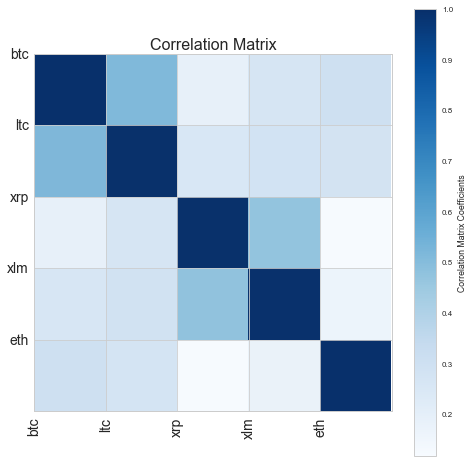

In [29]:
# Correlation matrix graph.

corr = np.corrcoef(crypto_df_raw.values.T)
plt.figure(figsize=(8, 8))
plt.imshow(corr, cmap='Blues', interpolation='none')
cb = plt.colorbar()
cb.set_label('Correlation Matrix Coefficients')
plt.title('Correlation Matrix', fontsize=16)

# Shift axes ticks b/c they defualt to center of squares.
ticks = np.arange(-0.5, len(CRYPTO_SCOPE), 1)
tick_labels = np.arange(1, len(CRYPTO_SCOPE), 1)
plt.xticks(ticks, CRYPTO_SCOPE, rotation=90, size=14)
plt.yticks(ticks, CRYPTO_SCOPE, size=14);

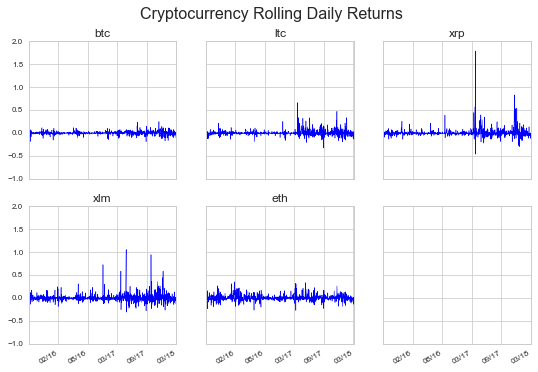

In [62]:
# Graph returns.

LW = 0.5  # line width
TS = 12  # subplot title size

# Number of rows and columns we'll need for all subplots.
INCHES_PER_ROW, INCHES_PER_COL = 3, 3
ax_rows, ax_cols = 2, 3
figsize = (ax_cols*INCHES_PER_COL, ax_rows*INCHES_PER_ROW)

# Create xticks so we have only 5 ticks.
desired_ticks = 5
days_per_tick = int(analysis_daycount/desired_ticks)
xticks = [analysis_start_dt + datetime.timedelta(days=x_*days_per_tick) for 
          x_ in range(1, desired_ticks+1)]

f, ax = plt.subplots(ax_rows, ax_cols, figsize=figsize,
                     sharex=True, sharey=True)
xaxis_fmt = mdates.DateFormatter('%m/%y')
row = 0
col = 0

for crypto in CRYPTO_SCOPE:
    ax[row, col].plot(crypto_df_raw[crypto], linewidth=LW)
    ax[row, col].set_title(crypto, size=TS)
    ax[row, col].set_xticks(xticks)
    ax[row, col].xaxis.set_major_formatter(xaxis_fmt)
    
    # Increment axis index.
    if ((col + 1)%ax_cols)==0:
        # Move to next row since we're at last column.
        col = 0
        row += 1
    else:
        col += 1

f.autofmt_xdate()
f.suptitle('Cryptocurrency Rolling Daily Returns', size=16)
plt.savefig('plots/daily_rolling_all.png', bbox_inches='tight')

# Prepare model data

#### Definition of rolling returns

We aim to One cryptocurrency's return will be the $Y$ value while the other currencies' returns will be the $X$.

In below example, `btc` is the cryptocurrency whose price return we try to predict. Therefore, one example of row in our training data would contain:
- Index: 3/30/2018
- $Y$: `btc`'s percentage change in `close` price from 3/29/2018 -> 3/30/2018.
- $X$: The other cryptocurrencies' percentage change in `close` price from 3/28/2018 -> 3/29/2018.

i.e., we want to use the rolling returns from the other cryptocurrencies on 3/29/2018 to predict the return of `btc` on the next day (3/30/2018).

For example, the price return for `eth` on original frame at 10/3/2017 was equal to $-0.329$. After shifting the returns forward one day in the following code, the price return for `eth` on 10/3/2017 becomes $-0.316$, the value for 10/2/2017 in the previous DF. 

In [5]:
y_currency = 'btc'  # crypto whose return we want to predict
x_currencies = [c for c in crypto_df.columns if c != y_currency]
crypto_df[x_currencies] = crypto_df[x_currencies].shift(periods=1, freq=tdelta)
crypto_df.dropna(axis=0, how='any', inplace=True)
crypto_df.head()

,btc,ltc,xrp,xlm,eth
date,,,,,
2015-08-09,0.277,-1.426,0.326,-0.140,-9.351
2015-08-10,-0.157,0.121,0.320,-0.386,-0.974
2015-08-11,0.440,0.118,-0.148,0.416,0.011
2015-08-12,-0.460,0.752,-0.266,-0.357,6.373
2015-08-13,-0.310,-0.725,-0.461,-0.161,1.673


## Replacing cryptocurrency returns with PCA components

In [6]:
# Placeholder

## Extracting news features using NLP

In [ ]:
# Placeholder

## Separate train/test

Once all feature engineering has been finished, i.e., design matrix is ready.

In [7]:
x_vars = x_currencies
train_cutoff = pd.to_datetime('6/1/2017')  # chosen arbitrarily

crypto_df_train = crypto_df[crypto_df.index <= train_cutoff]
crypto_df_test = crypto_df[crypto_df.index > train_cutoff]

X_train, X_test = crypto_df_train[x_vars], crypto_df_test[x_vars]
y_train, y_test = crypto_df_train[y_currency], crypto_df_test[y_currency]

# Build Model

## Establish Baseline Models

In [8]:
from sklearn.linear_model import LassoCV, Lasso
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import RidgeCV, Ridge

In [9]:
# Define hyperparam space for models where we will optimize hyperparams.
cv_alph_lasso = np.linspace(1e-3, 1e-1, 5)
cv_alph_ridge = range(10, 60, 10)
N_CV = 3  # k-folds over which to cross-validate

# Fit models / optimize hyperparams.
print_update('Fitting LR...')
lr = LinearRegression().fit(X_train, y_train)
print_update('Fitting Ridge...')
ridge = RidgeCV(alphas=cv_alph_ridge, cv=N_CV).fit(X_train, y_train)
print_update('Fitting Lasso...')
lasso = LassoCV(alphas=cv_alph_lasso, cv=N_CV).fit(X_train, y_train)
print_update('Finished fitting baseline models.')

In [10]:
# Evaluate model performance on test set.

models = [(lr, 'LR'), (ridge, 'Ridge'), (lasso, 'Lasso')]
df_scores = pd.DataFrame(columns=['model', 'train', 'test'])
for (model, name) in models:
    print_update('Evaluating {}...'.format(name))
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    new_row = {'model': name, 'train': train_score, 'test': test_score}
    df_scores = df_scores.append(new_row, ignore_index=True)
print_update('Finished evaluating baseline models.')
    
df_scores.sort_values('test', ascending=False, inplace=True)
display(df_scores)

,model,train,test
2,Lasso,0.000,-5.211e-04
1,Ridge,0.007,-1.857e-02
0,LR,0.007,-2.070e-02
